In [1]:
# Data wrangling
import pandas as pd
import numpy as np

# Deep learning: 
from keras.models import Sequential
from keras.layers import LSTM, Dense


class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X,(1, len(X), 1))

        return yhat 

In [2]:
# Reading the input data
d = pd.read_csv('C:/Users/shpva/OneDrive/Desktop/IndependentStudy_CIS5369/SM_Weather (4).csv', parse_dates=True)
print (d)

          Date  Temp Max  TempAvg  TempMin  Humidity Max  Humidity Avg  \
0    10/1/2021        81     61.4       43            59          50.4   
1    10/2/2021        79     59.1       40            47          39.5   
2    10/3/2021        74     61.5       48            41          32.0   
3    10/4/2021        78     66.1       54            44          35.4   
4    10/5/2021        78     69.6       59            73          53.9   
..         ...       ...      ...      ...           ...           ...   
234  5/23/2022        87     74.9       66            70          65.1   
235  5/24/2022        85     76.1       61            70          65.9   
236  5/25/2022        82     68.1       60            61          56.4   
237  5/26/2022        95     75.5       55            63          57.3   
238  5/27/2022        71     67.0       64            65          64.6   

     Humidity Min  Dew Point Max  Dew Point Avg  Dew Point Min  \
0              42             97           71

In [3]:
# Initiating the class
deep_learner = DeepModelTS(
data = d,
Y_var = 'TempAvg',
lag = 6,
LSTM_layer_depth = 50,
epochs = 100,
batch_size = 256,
train_test_split = 0.07
)

In [4]:
# Fitting the model
model = deep_learner.LSTModel()

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 2369.6572 - val_loss: 3426.7910
Epoch 2/100
1/1 [==============================] - 0s 46ms/step - loss: 2211.6101 - val_loss: 3155.2346
Epoch 3/100
1/1 [==============================] - 0s 44ms/step - loss: 2055.9785 - val_loss: 2879.4756
Epoch 4/100
1/1 [==============================] - 0s 38ms/step - loss: 1902.5121 - val_loss: 2606.0984
Epoch 5/100
1/1 [==============================] - 0s 44ms/step - loss: 1752.6021 - val_loss: 2357.5725
Epoch 6/100
1/1 [==============================] - 0s 42ms/step - loss: 1610.1923 - val_loss: 2146.2942
Epoch 7/100
1/1 [==============================] - 0s 44ms/step - loss: 1478.2596 - val_loss: 1960.7446
Epoch 8/100
1/1 [==============================] - 0s 48ms/step - loss: 1355.6721 - val_loss: 1779.8218
Epoch 9/100
1/1 [==============================] - 0s 41ms/step - loss: 1238.0006 - val_loss: 1594.4315
Epoch 10/100
1/1 [==============================] - 0s 44ms/step -

1/1 [==============================] - 0s 35ms/step - loss: 57.4665 - val_loss: 24.1499
Epoch 82/100
1/1 [==============================] - 0s 32ms/step - loss: 57.2024 - val_loss: 23.5253
Epoch 83/100
1/1 [==============================] - 0s 34ms/step - loss: 56.8388 - val_loss: 23.6424
Epoch 84/100
1/1 [==============================] - 0s 35ms/step - loss: 56.5550 - val_loss: 23.9038
Epoch 85/100
1/1 [==============================] - 0s 35ms/step - loss: 56.1735 - val_loss: 24.1216
Epoch 86/100
1/1 [==============================] - 0s 31ms/step - loss: 55.7716 - val_loss: 24.5903
Epoch 87/100
1/1 [==============================] - 0s 33ms/step - loss: 55.5639 - val_loss: 24.8408
Epoch 88/100
1/1 [==============================] - 0s 33ms/step - loss: 55.3864 - val_loss: 24.8397
Epoch 89/100
1/1 [==============================] - 0s 35ms/step - loss: 55.1194 - val_loss: 25.1516
Epoch 90/100
1/1 [==============================] - 0s 36ms/step - loss: 54.8500 - val_loss: 25.5375
Epo

In [5]:
# Defining the lag that we used for training of the model 
lag_model = 6
# Getting the last period
ts = d['TempAvg'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

1/1 [==============================] - 0s 239ms/step


In [6]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 24ms/step


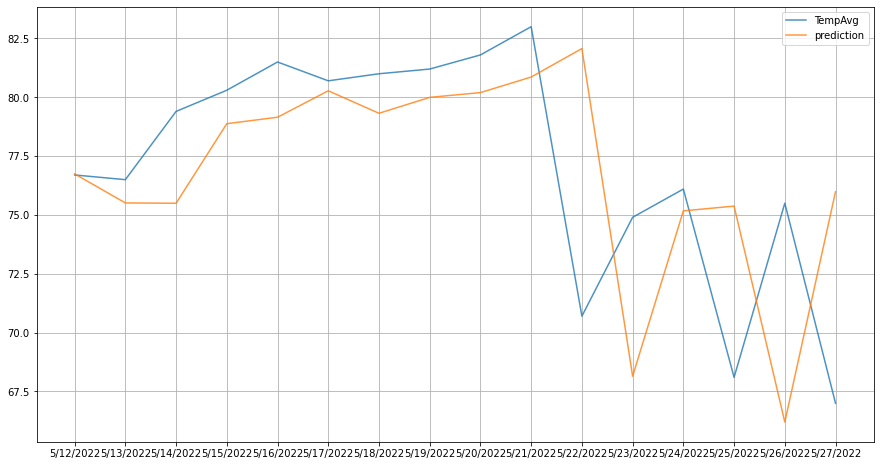

In [7]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = d.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['prediction'] = yhat
# Ploting the forecasts
plt.figure(figsize=(15, 8))
for dtype in ['TempAvg', 'prediction']:
    plt.plot(
    'Date',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()
plt.show()

In [8]:
model.save('TempLSTM_model.h5')

In [ ]:
model=model.load()